In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as transforms
from torch.utils.tensorboard import SummaryWriter
from torchvision.models import inception_v3

In [7]:
from torchvision import models
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, confusion_matrix
from PIL import Image
import glob
import shutil
from skimage.util import montage

In [8]:
import os
import cv2 
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [44]:
from skimage.io import imread
from glob import glob
%matplotlib inline 
import tensorflow as tf

import tensorflow.compat.v1.keras.backend as K
from keras.utils.np_utils import to_categorical
from keras.applications.inception_v3 import preprocess_input

from keras.applications.inception_v3 import InceptionV3 as Incep_v3
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Input, Conv2D, multiply, LocallyConnected2D, Lambda
from keras.models import Model
from keras.layers import BatchNormalization
from keras.metrics import top_k_categorical_accuracy
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from tqdm import tqdm_notebook
from tqdm import tqdm

import tensorflow_addons as tfa

In [10]:
# Set File Path
#files_path = 'C:/Users/ALi/Downloads/Adryn/diabetic-retinopathy-detection/'
files_path = os.path.join(os.path.expanduser("~"), "Downloads/diabetic-retinopathy-detection/")
# Set a default colour for all plots below
sns.set_palette(['steelblue','palevioletred', 'goldenrod','darkorchid' , 'mediumaquamarine'])

In [12]:
df['PatientId'] = df['image'].map(lambda x: x.split('_')[0])
df['PatientId'] = df['PatientId'].map(lambda x: x.replace(files_path,''))
df['exists'] = df['path'].map(os.path.exists)
print(df['exists'].sum(), 'images found of', df.shape[0], 'total')

500 images found of 500 total


In [17]:
train_df, temp_data = train_test_split(df, test_size=0.3, random_state=2018)
valid_df, test_df = train_test_split(temp_data, test_size=0.4, random_state=2018)

print(f"No. of training examples: {train_df.shape[0]}")
print(f"No. of validation examples: {valid_df.shape[0]}")
print(f"No. of testing examples: {test_df.shape[0]}")

No. of training examples: 350
No. of validation examples: 90
No. of testing examples: 60


In [45]:
def image_transformer(output_size, horizontal_flip = True, vertical_flip = True,
                      random_brightness = True, random_contrast = True,
                      random_hue = True, random_saturation = True,
                      preproc_func = preprocess_input,
                      color_mode = c_mode, on_batch = True):
        
  if color_mode == c_mode:
    channels = 3
  else:
    channels = 0

  def _func(image):
    with tf.name_scope('image_augmentation'):
      with tf.name_scope('input'):
        image = tf.image.decode_png(tf.io.read_file(image), channels = channels)
        image = tf.image.resize(image, output_size)
      with tf.name_scope('augmentation'):
        if horizontal_flip:
          image = tf.image.random_flip_left_right(image)
        if vertical_flip:
          image = tf.image.random_flip_up_down(image)
        if random_brightness:
          image = tf.image.random_brightness(image, max_delta = 0.1)
        if random_contrast:
          image = tf.image.random_contrast(image, lower = 0.75, upper = 1.5)
        if random_hue:
          image = tf.image.random_hue(image, max_delta = 0.15)
        if random_saturation:
          image = tf.image.random_saturation(image, lower = 0.75, upper = 1.5)
        return preproc_func(image)

  if on_batch:
    def _batch_func(image, y):
      return tf.map_fn(_func, image), y
    return _batch_func
  else:
    def _other_func(image, y):
      return _func(image), y
    return _other_func

In [56]:
def img_augmentation (output_size, intermediate_size = (640, 640), intermediate_trans = 'crop', batch_size = 16,
                      horizontal_flip = True,  vertical_flip = False, color_mode = c_mode, on_batch=False,
                      random_brightness = True, random_contrast = True, random_hue = True, random_saturation = True,
                      min_crop_percent = 0.001, max_crop_percent = 0.005, crop_probability = 0.5):
  if color_mode == c_mode:
    channels = 3
  else:
    channels = 0

  def _func(image):
    with tf.name_scope('image_augmentation'):
      with tf.name_scope('input'):
        image = tf.image.decode_png(tf.io.read_file(image), channels = channels)
        image = tf.image.resize(image, intermediate_size)
      with tf.name_scope('augmentation'):
        if flip_horizontal:
          image = tf.image.random_flip_left_right(image)
        if flip_vertical:
          image = tf.image.random_flip_up_down(image)
        if random_brightness:
          image = tf.image.random_brightness(image, max_delta = 0.1)
        if random_contrast:
          image = tf.image.random_contrast(image, lower = 0.75, upper = 1.5)
        if random_hue:
          image = tf.image.random_hue(image, max_delta = 0.15)
        if random_saturation:
          image = tf.image.random_saturation(image, lower = 0.75, upper = 1.5)
        return preproc_func(image)

  def _batch(image, y):
    if on_batch:
      image_transformer =  tf.map_fn(_func, image), y
    else:
      image_transformer =  _func(image), y

  @tf.function
  def _ops(Image, y):
    batch_size = tf.shape(Image)[0]
    with tf.name_scope('transformation'):
      # code from https://becominghuman.ai/data-augmentation-on-gpu-in-tensorflow-13d14ecf2b19
      transforms = []
      identity = tf.constant([1, 0, 0, 0, 1, 0, 0, 0], dtype = tf.float32)
      if crop_probability > 0:
        crop_pct = tf.random.uniform([batch_size], min_crop_percent, max_crop_percent)
        left = tf.random.uniform([batch_size], 0, intermediate_size[0] * (1.0 - crop_pct))
        top = tf.random.uniform([batch_size], 0, intermediate_size[1] * (1.0 - crop_pct))
        crop_transform = tf.stack([crop_pct, tf.zeros([batch_size]), top,
                                   tf.zeros([batch_size]), crop_pct, left,
                                   tf.zeros([batch_size]), tf.zeros([batch_size])], 1)
        coin = tf.less(tf.random.uniform([batch_size], 0, 1.0), crop_probability)
        transforms += [tf.where(coin, crop_transform, tf.tile(tf.expand_dims(identity, 0), [batch_size, 1]))]
      if len(transforms)>0:
        Image = tfa.image.transform(Image, tfa.image.compose_transforms(*transforms),
                                interpolation='BILINEAR') # 'BILINEAR' or 'NEAREST'
      if intermediate_trans=='scale':
        Image = tf.image.resize_images(Image, output_size)
      elif intermediate_trans=='crop':
        Image = tf.image.resize_with_crop_or_pad(Image, output_size[0], output_size[1])
      else:
        raise ValueError('Invalid Operation {}'.format(intermediate_trans))
      return Image, y
  
  img_trans = image_transformer(output_size = intermediate_size, horizontal_flip = horizontal_flip, 
                                vertical_flip = vertical_flip,
                               random_brightness = random_brightness, random_contrast = random_contrast, 
                               random_saturation = random_saturation, random_hue = random_hue,
                               color_mode = color_mode, preproc_func= preprocess_input, on_batch=False)
      
  def _pipeline(in_ds):
       batch_ds = in_ds.map(img_trans, num_parallel_calls=4).batch(batch_size)
       return batch_ds.map(_ops)
  return _pipeline

In [57]:
# Train augmentation includes vertical flip and random brightness etc are True
train_idg = img_augmentation(output_size = IMG_SIZE, color_mode =c_mode, crop_probability=0.0, 
                         horizontal_flip = False, vertical_flip = True, batch_size = batch_size,) 
valid_idg = img_augmentation(output_size = IMG_SIZE, color_mode =c_mode,  crop_probability=0.0, 
                         horizontal_flip = False, vertical_flip = False, 
                         random_brightness = False, random_contrast = False,
                         random_saturation = False, random_hue = False,
                         batch_size = batch_size)

In [64]:
model1.compile(optimizer = 'adam', loss = 'categorical_crossentropy',
                           metrics = ['categorical_accuracy', top_2_accuracy])
model1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 inception_v3 (Functional)      (None, 8, 8, 2048)   21802784    ['input_1[0][0]']                
                                                                                                  
 batch_normalization_94 (BatchN  (None, 8, 8, 2048)  8192        ['inception_v3[0][0]']           
 ormalization)                                                                                    
                                                                                              

In [65]:
weight_path="{}_weights.best.hdf5".format('retina')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=3, 
                                   verbose=1, mode='auto', min_delta=0.0001, 
                                   cooldown=5, min_lr=learning_rate)
early = EarlyStopping(monitor="val_loss", mode="min", patience=100) 
callbacks_list = [checkpoint, early, reduceLROnPlat]

In [68]:
##(c) Modelled Results
test_gen = df_flow(valid_idg, test_df, path_col = 'path', y_col = 'level_cat')
vbatch_count = (test_df.shape[0]//batch_size-1)
output_size = vbatch_count*batch_size
test_X = np.zeros((output_size,)+image.shape[1:], dtype = np.float32)
test_Y = np.zeros((output_size,)+label.shape[1:], dtype = np.float32)
for i, (c_x, c_y) in zip(tqdm_notebook(range(vbatch_count)),
                         test_gen):
    j = i*batch_size
    test_X[j:(j+c_x.shape[0])] = c_x
    test_Y[j:(j+c_x.shape[0])] = c_y

/var/folders/94/6tkz2qsx3qb75klfbj1q_f4c0000gn/T/ipykernel_56153/497250105.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, (c_x, c_y) in zip(tqdm_notebook(range(vbatch_count)),


  0%|          | 0/2 [00:00<?, ?it/s]

In [71]:
pred_Y = model1.predict(test_X, batch_size = batch_size, verbose = True)
pred_Y_cat = np.argmax(pred_Y, -1)
test_Y_cat = np.argmax(test_Y, -1)
print('Accuracy on Test Data: %2.2f%%' % (accuracy_score(test_Y_cat, pred_Y_cat)))
print(classification_report(test_Y_cat, pred_Y_cat))

/Users/adrynhan/anaconda3/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-09-04 15:18:02.285999: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_1/Softmax' id:8184 op device:{requested: '', assigned: ''} def:{{{node dense_1/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_1/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Accuracy on Test Data: 0.56%
              precision    recall  f1-score   support

           0       0.81      0.68      0.74        25
           1       0.00      0.00      0.00         0
           2       0.17      0.25      0.20         4
           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00         0

    accuracy                           0.56        32
   macro avg       0.20      0.19      0.19        32
weighted avg       0.65      0.56      0.60        32



/Users/adrynhan/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/adrynhan/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/adrynhan/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/adrynhan/anaconda3/l

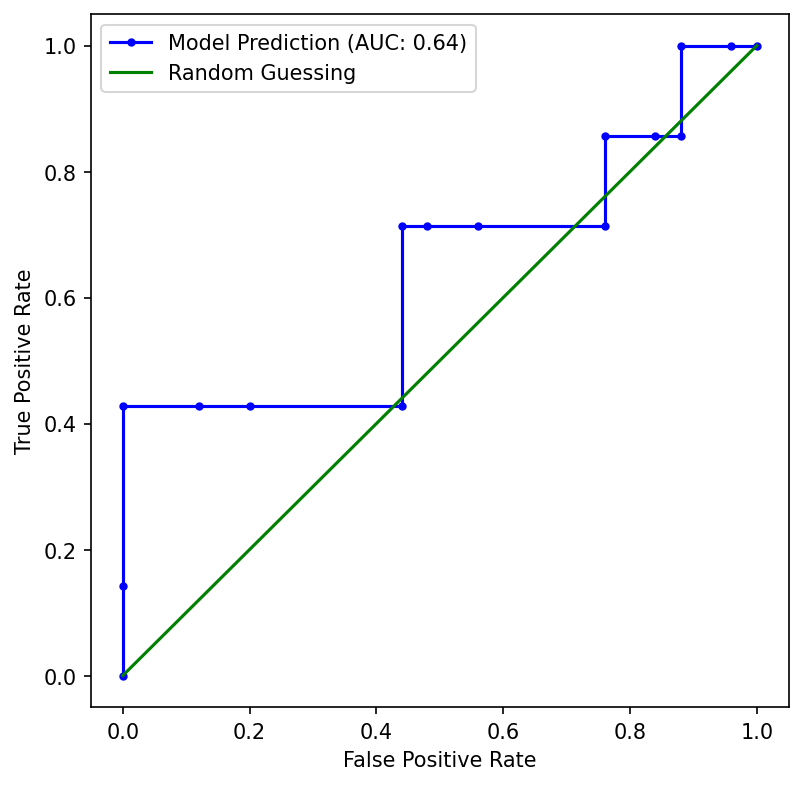

In [74]:
sick_vec = test_Y_cat>0
sick_score = np.sum(pred_Y[:,1:],1)
fpr, tpr, _ = roc_curve(sick_vec, sick_score)
fig, ax1 = plt.subplots(1,1, figsize = (6, 6), dpi = 150)
ax1.plot(fpr, tpr, 'b.-', label = 'Model Prediction (AUC: %2.2f)' % roc_auc_score(sick_vec, sick_score))
ax1.plot(fpr, fpr, 'g-', label = 'Random Guessing')
ax1.legend()
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate');

In [106]:
from __future__ import print_function
from keras.models import Sequential, Model
from keras.layers import Input, Reshape, Dense, Dropout, MaxPooling2D, Conv2D, Flatten
from keras.layers import Conv2DTranspose, LeakyReLU
from keras.layers.core import Activation
from tensorflow.keras.layers import BatchNormalization
#from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras import backend as K
from keras import initializers
import tensorflow as tf
import numpy as np
from tqdm import tqdm
import cv2
import math
from keras.utils. generic_utils import Progbar

In [107]:
### combine images for visualization
def combine_images(generated_images):
    num = generated_images.shape[0]
    width = int(math.sqrt(num))
    height = int(math.ceil(float(num)/width))
    shape = generated_images.shape[1:4]
    image = np.zeros((height*shape[0], width*shape[1], shape[2]),
                     dtype=generated_images.dtype)
    for index, img in enumerate(generated_images):
        i = int(index/width)
        j = index % width
        image[i*shape[0]:(i+1)*shape[0], j*shape[1]:(j+1)*shape[1],:] = img[:, :, :]
    return image

In [108]:
### generator model define
def generator_model():
    inputs = Input((10,))
    fc1 = Dense(input_dim=10, units=128*7*7)(inputs)
    fc1 = BatchNormalization()(fc1)
    fc1 = LeakyReLU(0.2)(fc1)
    fc2 = Reshape((7, 7, 128), input_shape=(128*7*7,))(fc1)
    up1 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(fc2)
    conv1 = Conv2D(64, (3, 3), padding='same')(up1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    up2 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv1)
    conv2 = Conv2D(1, (5, 5), padding='same')(up2)
    outputs = Activation('tanh')(conv2)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    return model

In [110]:
### d_on_g model for training generator
def generator_containing_discriminator(g, d):
    d.trainable = False
    ganInput = Input(shape=(10,))
    x = g(ganInput)
    ganOutput = d(x)
    gan = Model(inputs=ganInput, outputs=ganOutput)
    # gan.compile(loss='binary_crossentropy', optimizer='adam')
    return gan

def load_model():
    d = discriminator_model()
    g = generator_model()
    d_optim = RMSprop()
    g_optim = RMSprop(lr=0.0002)
    g.compile(loss='binary_crossentropy', optimizer=g_optim)
    d.compile(loss='binary_crossentropy', optimizer=d_optim)
    d.load_weights('./weights/discriminator.h5')
    g.load_weights('./weights/generator.h5')
    return g, d

In [111]:
### train generator and discriminator
def train(BATCH_SIZE, X_train):
    
    ### model define
    d = discriminator_model()
    g = generator_model()
    d_on_g = generator_containing_discriminator(g, d)
    d_optim = RMSprop(lr=0.0004)
    g_optim = RMSprop(lr=0.0002)
    g.compile(loss='mse', optimizer=g_optim)
    d_on_g.compile(loss='mse', optimizer=g_optim)
    d.trainable = True
    d.compile(loss='mse', optimizer=d_optim)
    

    for epoch in range(10):
        print ("Epoch is", epoch)
        n_iter = int(X_train.shape[0]/BATCH_SIZE)
        progress_bar = Progbar(target=n_iter)
        
        for index in range(n_iter):
            # create random noise -> U(0,1) 10 latent vectors
            noise = np.random.uniform(0, 1, size=(BATCH_SIZE, 10))

            # load real data & generate fake data
            image_batch = X_train[index*BATCH_SIZE:(index+1)*BATCH_SIZE]
            generated_images = g.predict(noise, verbose=0)
            
            # visualize training results
            if index % 20 == 0:
                image = combine_images(generated_images)
                image = image*127.5+127.5
                cv2.imwrite('./result/'+str(epoch)+"_"+str(index)+".png", image)

            # attach label for training discriminator
            X = np.concatenate((image_batch, generated_images))
            y = np.array([1] * BATCH_SIZE + [0] * BATCH_SIZE)
            
            # training discriminator
            d_loss = d.train_on_batch(X, y)

            # training generator
            d.trainable = False
            g_loss = d_on_g.train_on_batch(noise, np.array([1] * BATCH_SIZE))
            d.trainable = True

            progress_bar.update(index, values=[('g',g_loss), ('d',d_loss)])
        print ('')

        # save weights for each epoch
        g.save_weights('weights/generator.h5', True)
        d.save_weights('weights/discriminator.h5', True)
    return d, g



In [112]:
### generate images
def generate(BATCH_SIZE):
    g = generator_model()
    g.load_weights('weights/generator.h5')
    noise = np.random.uniform(0, 1, (BATCH_SIZE, 10))
    generated_images = g.predict(noise)
    return generated_images

In [113]:
### anomaly loss function 
def sum_of_residual(y_true, y_pred):
    return K.sum(K.abs(y_true - y_pred))

In [114]:
### discriminator intermediate layer feautre extraction
def feature_extractor(d=None):
    if d is None:
        d = discriminator_model()
        d.load_weights('weights/discriminator.h5') 
    intermidiate_model = Model(inputs=d.layers[0].input, outputs=d.layers[-7].output)
    intermidiate_model.compile(loss='binary_crossentropy', optimizer='rmsprop')
    return intermidiate_model

In [115]:
### anomaly detection model define
def anomaly_detector(g=None, d=None):
    if g is None:
        g = generator_model()
        g.load_weights('weights/generator.h5')
    intermidiate_model = feature_extractor(d)
    intermidiate_model.trainable = False
    g = Model(inputs=g.layers[1].input, outputs=g.layers[-1].output)
    g.trainable = False
    # Input layer cann't be trained. Add new layer as same size & same distribution
    aInput = Input(shape=(10,))
    gInput = Dense((10), trainable=True)(aInput)
    gInput = Activation('sigmoid')(gInput)
    
    # G & D feature
    G_out = g(gInput)
    D_out= intermidiate_model(G_out)    
    model = Model(inputs=aInput, outputs=[G_out, D_out])
    model.compile(loss=sum_of_residual, loss_weights= [0.90, 0.10], optimizer='rmsprop')
    
    # batchnorm learning phase fixed (test) : make non trainable
    K.set_learning_phase(0)
    
    return model

In [116]:
### anomaly detection
def compute_anomaly_score(model, x, iterations=500, d=None):
    z = np.random.uniform(0, 1, size=(1, 10))
    
    intermidiate_model = feature_extractor(d)
    d_x = intermidiate_model.predict(x)

    # learning for changing latent
    loss = model.fit(z, [x, d_x], batch_size=1, epochs=iterations, verbose=0)
    similar_data, _ = model.predict(z)
    
    loss = loss.history['loss'][-1]
    
    return loss, similar_data

In [95]:
from __future__ import print_function
import matplotlib
matplotlib.use('Qt5Agg')
from keras import layers
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
import argparse

import xlwt
from skimage.exposure import equalize_hist
from skimage.util.shape import view_as_blocks

In [97]:
import anogan

ModuleNotFoundError: No module named 'anogan'

In [117]:
parser = argparse.ArgumentParser()
parser.add_argument('--img_idx', type=int, default=14)
parser.add_argument('--label_idx', type=int, default=7)
parser.add_argument('--mode', type=str, default='train', help='train, test')
args = parser.parse_args()

usage: ipykernel_launcher.py [-h] [--img_idx IMG_IDX] [--label_idx LABEL_IDX]
                             [--mode MODE]
ipykernel_launcher.py: error: unrecognized arguments: -f /Users/adrynhan/Library/Jupyter/runtime/kernel-4ecc5dde-2f17-451e-9496-a82e54b19c7c.json


SystemExit: 2

In [ ]:
def anomaly_detection(test_img, g=None, d=None):
    model = anomaly_detector(g=g, d=d)
    
    ano_score, similar_img = compute_anomaly_score(model, test_img.reshape(1, 128, 128, 1), iterations=800, d=d)

    np_residual = np.abs(test_img.reshape(128, 128,1)- similar_img.reshape(128, 128,1))
    np_residual = (np_residual + 2)/4

    np_residual = (255*np_residual).astype(np.uint8)
    original_x = (test_img.reshape(128, 128,1)*127.5 + 127.5).astype(np.uint8)
    similar_x = (similar_img.reshape(128, 128,1)*127.5 + 127.5).astype(np.uint8)

    original_x_color = cv2.cvtColor(original_x, cv2.COLOR_GRAY2BGR)
    residual_color = cv2.applyColorMap(np_residual, cv2.COLORMAP_JET)
    show = cv2.addWeighted(original_x_color, 0.3, residual_color, 0.7, 0.)

    return ano_score, original_x, similar_x, show

In [ ]:
normal = []
norm_all = []
wb = xlwt.Workbook()
worksheet = wb.add_sheet('Sheet 1')
for i in range(test_img.shape[0]):
    test_im = test_img[i]
    score, qurey, pred, diff = anomaly_detection(test_im)
    normal.append(score)
    worksheet.write(i + 1, 1, score)
    worksheet.write(i + 1, 2, np.count_nonzero(qurey != 0))
    worksheet.write(i + 1, 3, score / np.sqrt(np.count_nonzero(qurey != 0)))
wb.save('./modified/pneumonia_anomalyscores.xls')
### 4. tsne feature view
normal = np.array(normal)
print("MEAN", np.mean(normal))
print("MEDIAN", np.median(normal))
print("MIN", np.min(normal))
print("MAX", np.max(normal))

### t-SNE embedding 
### generating anomaly image for test (radom noise image)

In [4]:
#conda install libjpeg-dev -c nvidia     

SyntaxError: invalid syntax (280862437.py, line 2)

## 1. Import Packages

## 2. Data Import

In [11]:
df = pd.read_csv(f"{files_path}trainLabels.csv")[:500]
df['path'] = df['image'].apply(lambda x: f"{files_path}" + f"train/" +x + ".jpeg")
df.head()

image  level                                               path
0   10_left      0  /Users/adrynhan/Downloads/diabetic-retinopathy...
1  10_right      0  /Users/adrynhan/Downloads/diabetic-retinopathy...
2   13_left      0  /Users/adrynhan/Downloads/diabetic-retinopathy...
3  13_right      0  /Users/adrynhan/Downloads/diabetic-retinopathy...
4   15_left      1  /Users/adrynhan/Downloads/diabetic-retinopathy...

In [13]:
df['eye'] = df['image'].map(lambda x: 1 if x.split('_')[-1]=='left' else 0)
df['level_cat'] = df['level'].map(lambda x: to_categorical(x, 1+df['level'].max()))

df.dropna(inplace = True)
df = df[df['exists']]
df.sample(3)

image  level                                               path  \
397  451_right      0  /Users/adrynhan/Downloads/diabetic-retinopathy...   
24     31_left      0  /Users/adrynhan/Downloads/diabetic-retinopathy...   
302   355_left      0  /Users/adrynhan/Downloads/diabetic-retinopathy...   

    PatientId  exists  eye                  level_cat  
397       451    True    0  [1.0, 0.0, 0.0, 0.0, 0.0]  
24         31    True    1  [1.0, 0.0, 0.0, 0.0, 0.0]  
302       355    True    1  [1.0, 0.0, 0.0, 0.0, 0.0]

## 3. Exploratory Data Analysis (EDA)

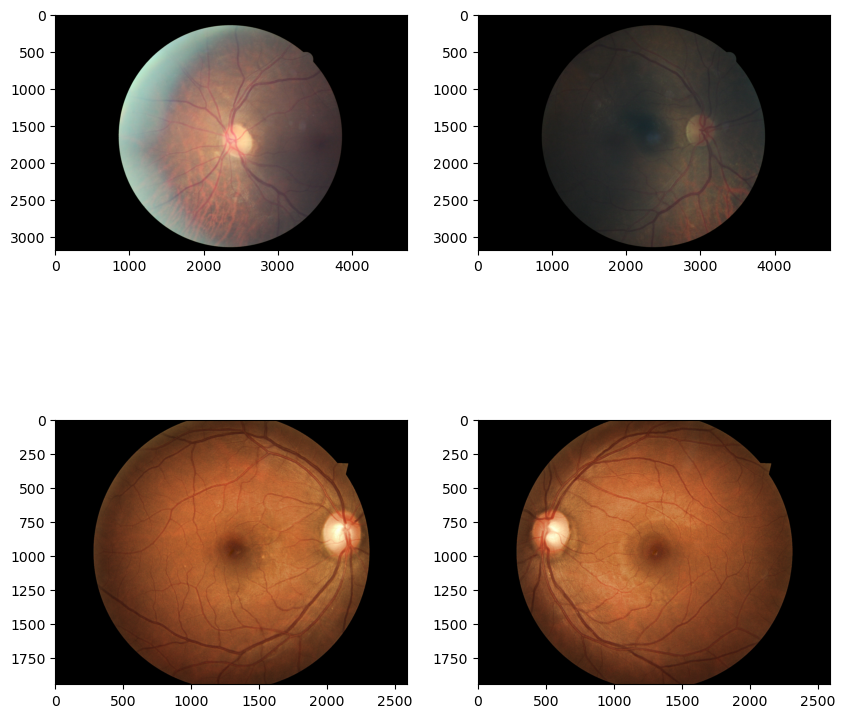

In [14]:
f, axarr = plt.subplots(2,2, figsize=(10, 10))
axarr[0,0].imshow(Image.open(f"{files_path}/train/10_left.jpeg"))
axarr[0,1].imshow(Image.open(f"{files_path}/train/10_right.jpeg"))
axarr[1,0].imshow(Image.open(f"{files_path}/train/13_right.jpeg"))
axarr[1,1].imshow(Image.open(f"{files_path}/train/13_left.jpeg"))

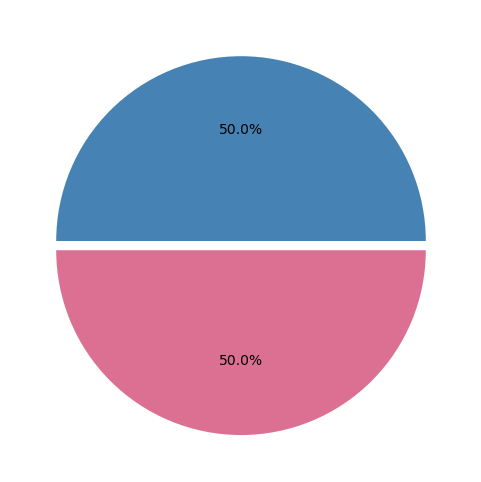

In [16]:
# Set the figure's size
plt.figure(figsize=(6,6))
# Create a Pie Chart for gender
plt.pie(x = df['eye'].value_counts(), explode = [0, 0.05], autopct='%0.01f%%')
plt.show()

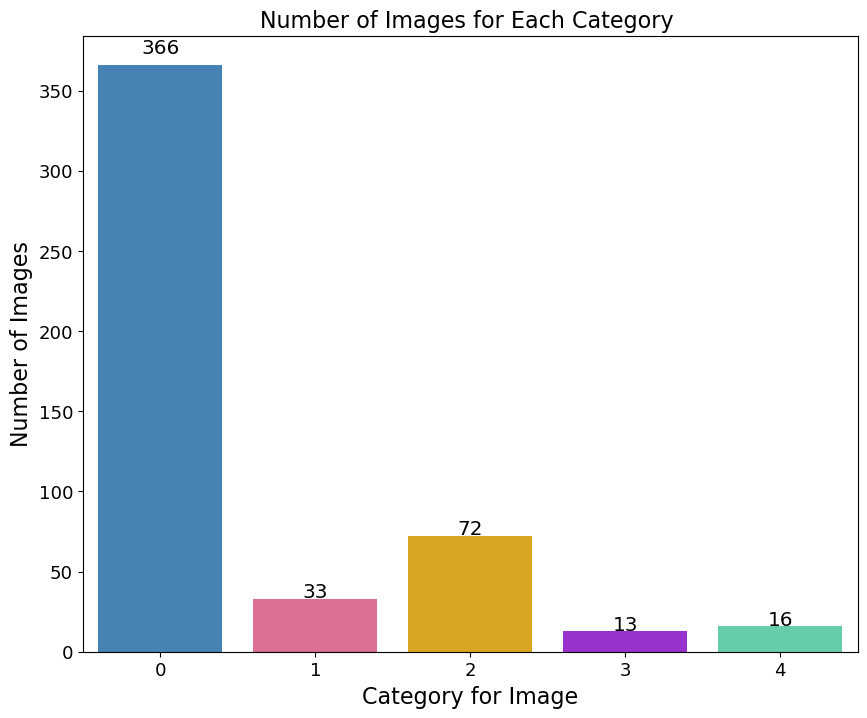

In [15]:
plt.rcParams['figure.figsize'] = 10, 8
num_classes = len(np.unique(df['level']))
class_dist = [len(df.loc[df['level'] == x]) for x in range(num_classes)]
ax = sns.barplot(x = np.unique(df['level']), y = class_dist, saturation =1.5)
plt.xlabel("Category for Image", fontsize = 16 )
plt.ylabel("Number of Images", fontsize = 16)
plt.title("Number of Images for Each Category ", fontsize = 16)
plt.xticks(fontsize = 13, horizontalalignment = 'center', rotation = 0)
plt.yticks(fontsize = 13)
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{height:.0f}', (x + width/2, y + height*1.02), ha='center', fontsize = 'x-large')
plt.show()

## 4. Spilt Data

## 5. Define fixed variables and functions

In [18]:
# Setting some fixed value
batch_size = 16
epochs = 10
learning_rate = 1e-4
IMG_SIZE = (299, 299)
c_mode = 'rgb'

In [47]:
def df_flow(transformed_data, input_df, path_col, y_col, color_mode = c_mode, shuffle = True):
    file = tf.data.Dataset.from_tensor_slices((input_df[path_col].values,
                                                   np.stack(input_df[y_col].values,0)))
    input_len = input_df[path_col].values.shape[0]
    while True:
        if shuffle:
            file = file.shuffle(input_len)
        next = transformed_data(file).repeat()
        next = tf.compat.v1.data.make_one_shot_iterator(next).get_next()
        for i in range(max(input_len // 32,1)):
            yield K.get_session().run(next)

In [48]:
def view_img (input_gen):
    image, label = next(input_gen)
    fig, m_axs = plt.subplots(2,2, figsize=(10, 10))
    for (img_x, img_y, img_ax) in zip(image, label, m_axs.flatten()):
        img_ax.imshow(np.clip(img_x * 127 + 127, 0, 255).astype(np.uint8))
        img_ax.set_title('Severity {}'.format(np.argmax(img_y, -1)))
        img_ax.axis('off')

In [63]:
def top_2_accuracy(in_gt, in_pred):
    return top_k_categorical_accuracy(in_gt, in_pred, k=2)

## 6. Model 1 - Tensorflow v2 Inception v3

In [58]:
train_gen = df_flow(train_idg, train_df, 'path', 'level_cat')
valid_gen = df_flow(valid_idg, valid_df, 'path', 'level_cat')
test_gen = df_flow(valid_idg, test_df,  'path', 'level_cat')

Metal device set to: Apple M1 Max



2023-09-04 14:58:46.910207: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


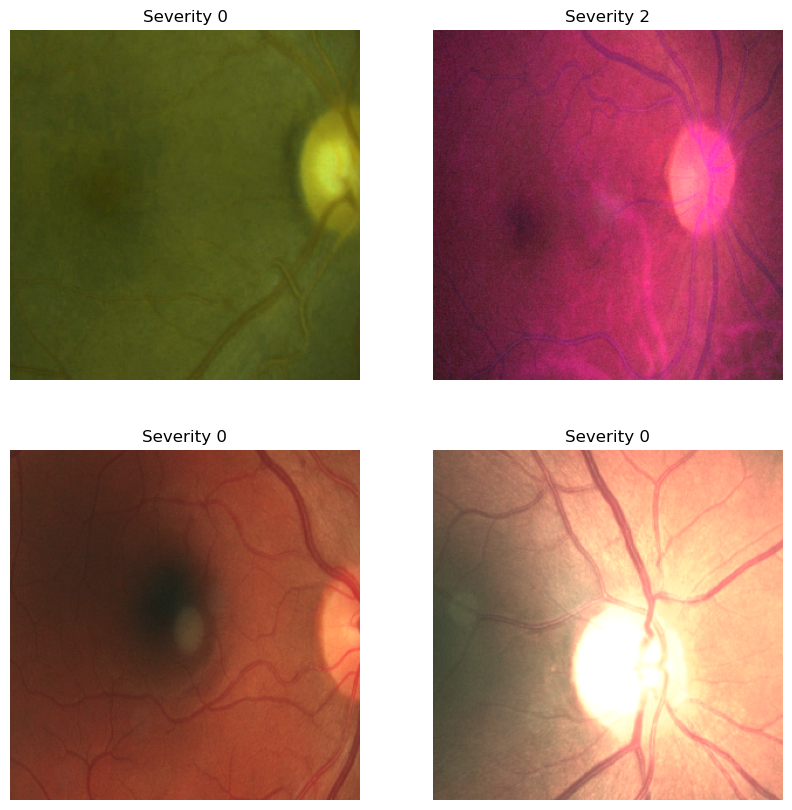

In [59]:
tf.compat.v1.disable_eager_execution() # disable eager execution
view_img(train_gen)

In [61]:
image, label = next(train_gen)
input_layer = Input(image.shape[1:])
base_model = Incep_v3(input_shape =  image.shape[1:], include_top = False, weights = 'imagenet')
base_model.trainable = False   # Set trainable weights to empty
pt_features = base_model(input_layer)
pt_depth = base_model.get_output_shape_at(0)[-1]

Instructions for updating:
Colocations handled automatically by placer.


2023-09-04 15:00:09.343474: W tensorflow/c/c_api.cc:300] Operation '{name:'batch_normalization_54/moving_variance/Assign' id:3266 op device:{requested: '', assigned: ''} def:{{{node batch_normalization_54/moving_variance/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](batch_normalization_54/moving_variance, batch_normalization_54/moving_variance/Initializer/ones)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


In [62]:
bn_features = BatchNormalization()(pt_features)

# here we do an attention mechanism to turn pixels in the GAP on an off
attn_layer = Conv2D(64, kernel_size = (1,1), padding = 'same', activation = 'relu')(Dropout(0.5)(bn_features))
attn_layer = Conv2D(16, kernel_size = (1,1), padding = 'same', activation = 'relu')(attn_layer)
attn_layer = Conv2D(8, kernel_size = (1,1), padding = 'same', activation = 'relu')(attn_layer)
attn_layer = Conv2D(1, kernel_size = (1,1), padding = 'valid', activation = 'sigmoid')(attn_layer)
# fan it out to all of the channels
up_c2_w = np.ones((1, 1, 1, pt_depth))
up_c2 = Conv2D(pt_depth, kernel_size = (1,1), padding = 'same', 
               activation = 'linear', use_bias = False, weights = [up_c2_w])
up_c2.trainable = False
attn_layer = up_c2(attn_layer)

mask_features = multiply([attn_layer, bn_features])
gap_features = GlobalAveragePooling2D()(mask_features)
gap_mask = GlobalAveragePooling2D()(attn_layer)
# to account for missing values from the attention model
gap = Lambda(lambda x: x[0]/x[1], name = 'RescaleGAP')([gap_features, gap_mask])
gap_dr = Dropout(0.25)(gap)
dr_steps = Dropout(0.25)(Dense(128, activation = 'relu')(gap_dr))
output_layer = Dense(label.shape[-1], activation = 'softmax')(dr_steps)
model1 = Model(inputs = [input_layer], outputs = [output_layer])

2023-09-04 15:00:32.070394: W tensorflow/c/c_api.cc:300] Operation '{name:'batch_normalization_94/moving_variance/Assign' id:7946 op device:{requested: '', assigned: ''} def:{{{node batch_normalization_94/moving_variance/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](batch_normalization_94/moving_variance, batch_normalization_94/moving_variance/Initializer/ones)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


In [66]:
model1.fit(train_gen, steps_per_epoch = train_df.shape[0]//batch_size,
           validation_data = valid_gen, validation_steps = valid_df.shape[0]//batch_size,
           epochs = epochs, callbacks = callbacks_list,
           workers = 0, # tf-generators are not thread-safe
           use_multiprocessing=False, max_queue_size = 0)

2023-09-04 15:01:31.216183: W tensorflow/c/c_api.cc:300] Operation '{name:'dense/kernel/Assign' id:8140 op device:{requested: '', assigned: ''} def:{{{node dense/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense/kernel, dense/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/10


2023-09-04 15:01:31.849336: W tensorflow/c/c_api.cc:300] Operation '{name:'batch_normalization_94/AssignMovingAvg_1/AssignSubVariableOp' id:7973 op device:{requested: '', assigned: ''} def:{{{node batch_normalization_94/AssignMovingAvg_1/AssignSubVariableOp}} = AssignSubVariableOp[_class=["loc:@batch_normalization_94/moving_variance"], _has_manual_control_dependencies=true, dtype=DT_FLOAT](batch_normalization_94/moving_variance, batch_normalization_94/AssignMovingAvg_1/mul)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-09-04 15:01:32.079827: W tensorflow/c/c_api.cc:300] Operation '{name:'training/Adam/conv2d_95/bias/v/Assign' id:8643 op device:{requested: '', assigned: ''} def:{{{node training/Adam/conv2d_95/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false

21/21 [==============================] - ETA: 0s - batch: 10.0000 - size: 16.0000 - loss: 1.0650 - categorical_accuracy: 0.6429 - top_2_accuracy: 0.8512

/Users/adrynhan/anaconda3/lib/python3.10/site-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2023-09-04 15:01:38.759840: W tensorflow/c/c_api.cc:300] Operation '{name:'loss/mul' id:8289 op device:{requested: '', assigned: ''} def:{{{node loss/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss/mul/x, loss/dense_1_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.



Epoch 1: val_loss improved from inf to 3.83998, saving model to retina_weights.best.hdf5
21/21 [==============================] - 10s 447ms/step - batch: 10.0000 - size: 16.0000 - loss: 1.0650 - categorical_accuracy: 0.6429 - top_2_accuracy: 0.8512 - val_loss: 3.8400 - val_categorical_accuracy: 0.0125 - val_top_2_accuracy: 0.1125 - lr: 0.0010
Epoch 2/10
21/21 [==============================] - ETA: 0s - batch: 10.0000 - size: 16.0000 - loss: 0.8463 - categorical_accuracy: 0.7202 - top_2_accuracy: 0.8929
Epoch 2: val_loss improved from 3.83998 to 2.91092, saving model to retina_weights.best.hdf5
21/21 [==============================] - 7s 357ms/step - batch: 10.0000 - size: 16.0000 - loss: 0.8463 - categorical_accuracy: 0.7202 - top_2_accuracy: 0.8929 - val_loss: 2.9109 - val_categorical_accuracy: 0.0625 - val_top_2_accuracy: 0.1500 - lr: 0.0010
Epoch 3/10
21/21 [==============================] - ETA: 0s - batch: 10.0000 - size: 16.0000 - loss: 0.7690 - categorical_accuracy: 0.7381 - t

In [67]:
# load the best version of the model
model1.load_weights(weight_path)
model1.save('full_retina_model.h5')

In [69]:
# get the attention layer since it is the only one with a single output dim
for layer in model1.layers:
    shape = layer.get_output_shape_at(0)
    if len(shape)==4:
        if shape[-1]==1:
            print(layer)
            break

<Axes: >

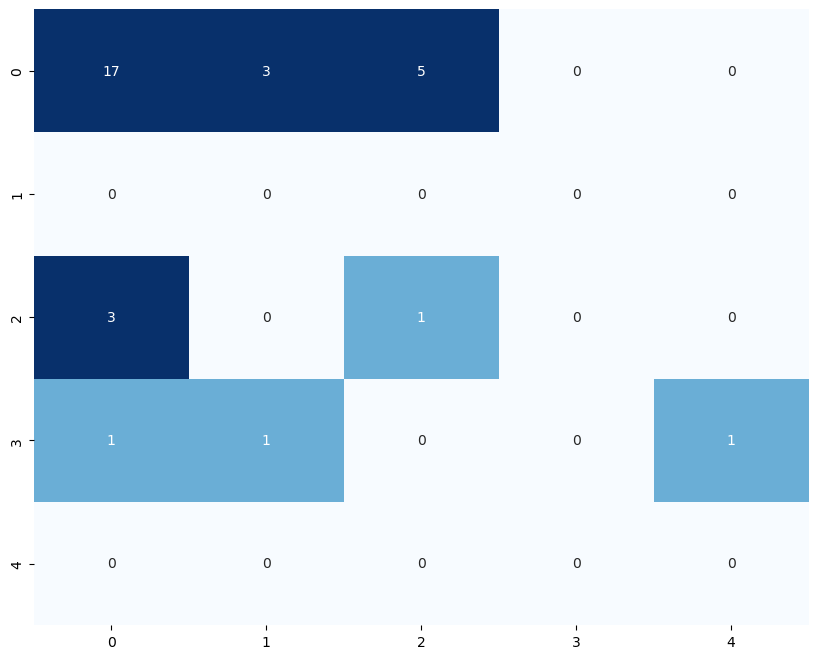

In [73]:
sns.heatmap(confusion_matrix(test_Y_cat, pred_Y_cat), 
            annot=True, fmt="d", cbar = False, cmap = plt.cm.Blues, vmax = test_X.shape[0]//16)

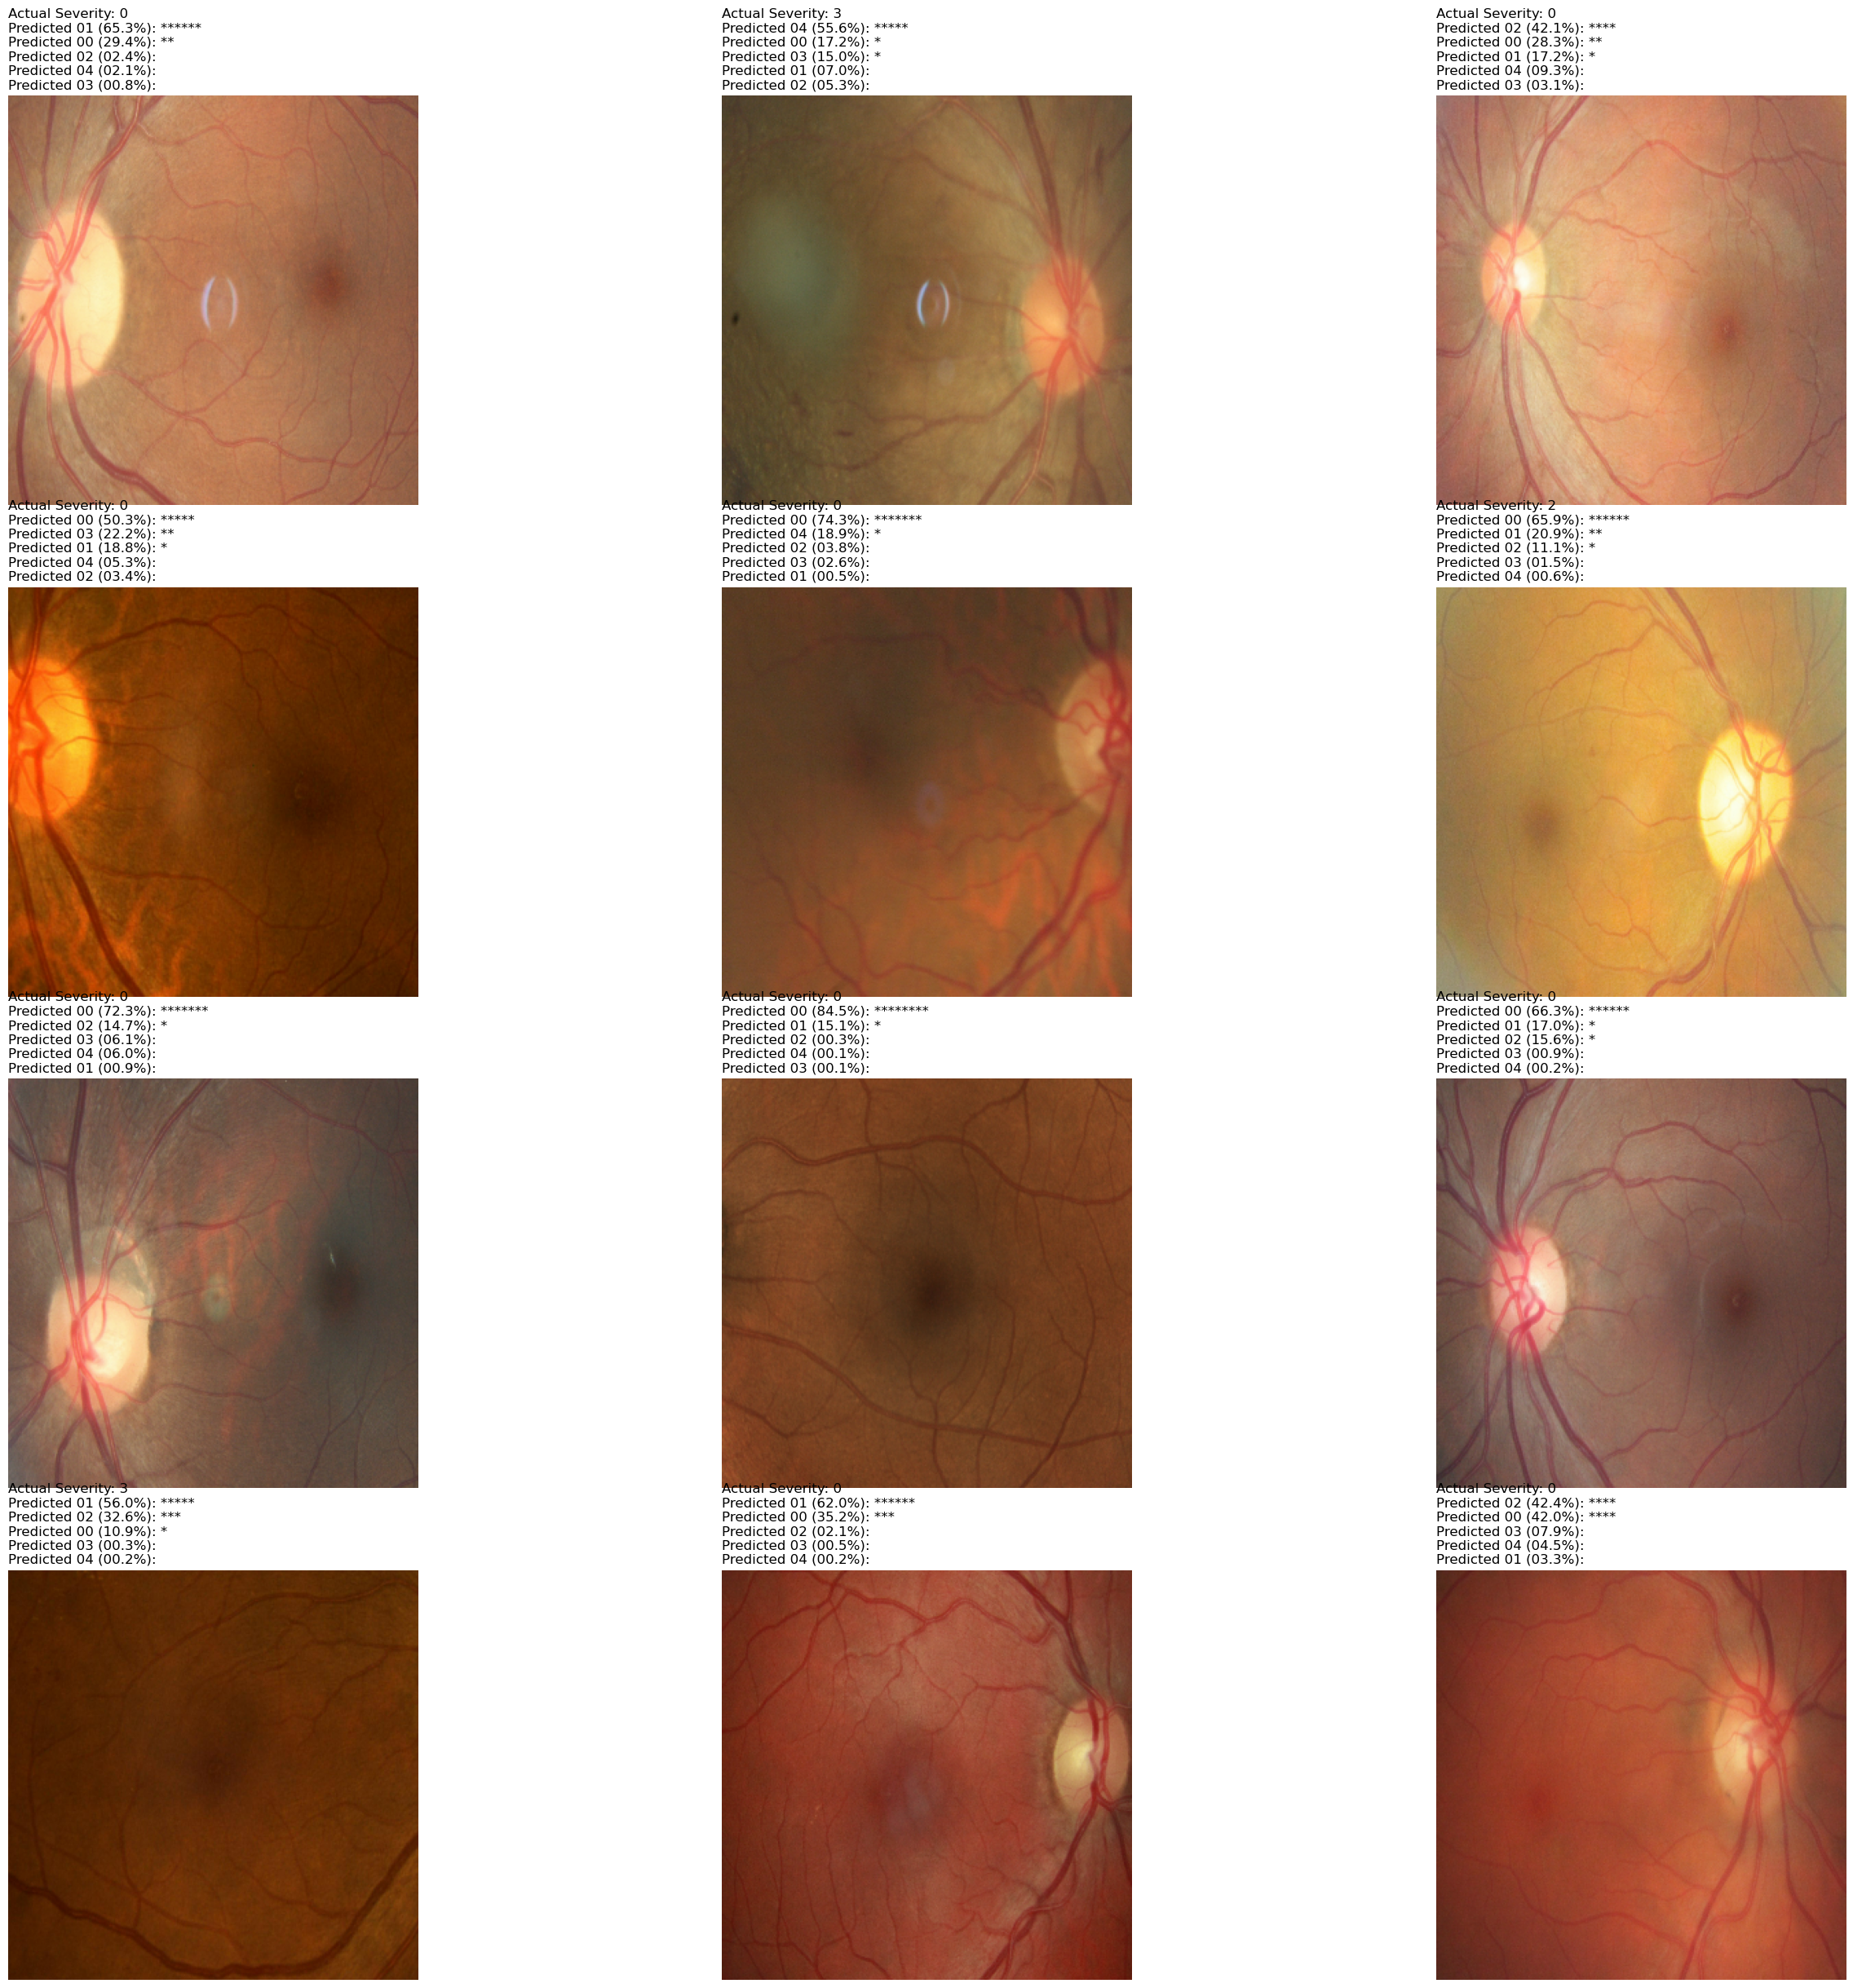

In [72]:
fig, m_axs = plt.subplots(4,3, figsize = (32, 30))
for (idx, c_ax) in enumerate(m_axs.flatten()):
    c_ax.imshow(np.clip(test_X[idx]*127+127,0 , 255).astype(np.uint8), cmap = 'bone')
    c_ax.set_title('Actual Severity: {}\n{}'.format(test_Y_cat[idx],
                                                           '\n'.join(['Predicted %02d (%04.1f%%): %s' % (k, 100*v, '*'*int(10*v)) for k, v in sorted(enumerate(pred_Y[idx]), key = lambda x: -1*x[1])])), loc='left')
    c_ax.axis('off')
fig.savefig('trained_img_predictions.png', dpi = 300)

## 7. Model 2: Pytoch Inception v3

https://github.com/tkwoo/anogan-keras/blob/master/anogan.py

In [109]:
### discriminator model define
def discriminator_model():
    inputs = Input((28, 28, 1))
    conv1 = Conv2D(64, (5, 5), padding='same')(inputs)
    conv1 = LeakyReLU(0.2)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, (5, 5), padding='same')(pool1)
    conv2 = LeakyReLU(0.2)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    fc1 = Flatten()(pool2)
    fc1 = Dense(1)(fc1)
    outputs = Activation('sigmoid')(fc1)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    return model

## 9. Model 4: RANDGAN

https://github.com/sam-motamed/RANDGAN/blob/main/main.py

In [119]:
### 0. prepare data
X_train = train_df
#np.save('pneu_610', X_train[:610])
#X_train = X_train.reshape(-1, 128, 128, 1)
#X_train = X_train.astype(np.float32)
min_scal = X_train.min()
max_scal = X_train.max()
X_train = X_train.astype(np.float32) 
print(min_scal, max_scal)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [123]:
### 0. prepare data
X_train = train_df

In [124]:
if args.mode == 'train':
    Model_d, Model_g = train(32, X_train)

NameError: name 'args' is not defined

In [ ]:
test_img = np.load('./data/seg_pneumonia_test.npy').reshape(-1, 128, 128, 1)
print("test size", np.shape(test_img))

In [ ]:
print("test min and max", np.min(test_img), np.max(test_img))